# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

In [36]:
%pip install pandas
%pip install fastparquet
%pip install pandas xlrd
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 8.1/8.1 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 111.1/111.1 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 221.2/221.2 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 73.7/73.7 kB 4.2 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.3/2.3 MB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? 
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [ ]:
# Number 1

import pandas as pd

df = pd.read_csv("./data/airbnb_hw.csv")

df['Price'].head(10)

df['Price_clean'] = (
    df['Price']
    .astype(str)                      # ensure string
    .str.replace("$", "", regex=False)  # remove $
    .str.replace(",", "", regex=False)  # remove commas
    .str.strip()                        # remove spaces
)

df['Price_clean'] = pd.to_numeric(df['Price_clean'], errors='coerce')

print(f"Missing values after cleaning: {df['Price_clean'].isna().sum()}")


Missing values after cleaning: 0


In [19]:
# Number 2

df2 = pd.read_csv("./data/mn_police_use_of_force.csv")

df2['subject_injury_clean'] = (
    df2['subject_injury']
    .str.strip()
    .str.capitalize()
    .replace(
        {'Nan': pd.NA, '': pd.NA}
    )
)

missing_count_mean = df2['subject_injury_clean'].isna().mean()
print(f"Proportion missing: {missing_count_mean:.2%}")

# Cross-tabulate with force_type
ct = pd.crosstab(df['subject_injury_clean'], df['force_type'], dropna=False)
print(ct)




Proportion missing: 76.19%
force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury_clean                                                    
Nan                       2          7051               1421        0   
No                        0          1093                131        2   
Yes                       2          1286                 41        0   

force_type            Gun Point Display  Improvised Weapon  Less Lethal  \
subject_injury_clean                                                      
Nan                                  27                 74           87   
No                                   33                 34            0   
Yes                                  44                 40            0   

force_type            Less Lethal Projectile  Maximal Restraint Technique  \
subject_injury_clean                                                        
Nan                                        0                          170   


Number 2

76.19% of the values are missing. Yes that is a concern. For patterns, bodily force seems to be the highest category of data missing. Chemical irritant and taser seem to be a close second.

In [ ]:
# Number 3

import numpy as np

justice = pd.read_parquet("./data/justice_data.parquet", engine="fastparquet")

justice['released_clean'] = (
    justice['WhetherDefendantWasReleasedPretrial']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Map to Yes/No
justice['released_clean'] = justice['released_clean'].replace({
    'yes': 'Yes',
    'y': 'Yes',
    'released': 'Yes',
    'no': 'No',
    'n': 'No',
    'not released': 'No',
    'nan': np.nan,
    '': np.nan,
})

justice['released_dummy'] = justice['released_clean'].map({'Yes': 1, 'No': 0})

In [ ]:
# Number 4

justice['ImposedSentenceAllChargeInContactEvent'].value_counts(dropna=False)
justice['SentenceTypeAllChargesAtConvictionInContactEvent'].value_counts(dropna=False)

justice['imposed_sentence_clean'] = pd.to_numeric(
    justice['ImposedSentenceAllChargeInContactEvent'], errors='coerce'
)

missing_count = justice['imposed_sentence_clean'].isna().sum()
total_count = len(justice)
missing_prop = missing_count / total_count
print(f"Missing values: {missing_count} ({missing_prop:.2%})")

Missing values: 9053 (39.38%)


Number 4

I cleaned the ImposedSentenceAllChargeInContactEvent variable by converting it to numeric and keeping missing values as np.nan. The missing values were not filled because they are informative. They mostly occur for cases with non-custodial sentences or dismissals, as confirmed by examining the SentenceTypeAllChargesAtConvictionInContactEvent variable. This ensures the data accurately represents both recorded sentences and absent sentences.

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

In [34]:
# Number 1

# Open the shark attack file
df = pd.read_excel("./data/GSAF5.xls")


In [ ]:
# Number 2

# Drop any columns that do not contain data
df = df.dropna(axis=1, how='all')

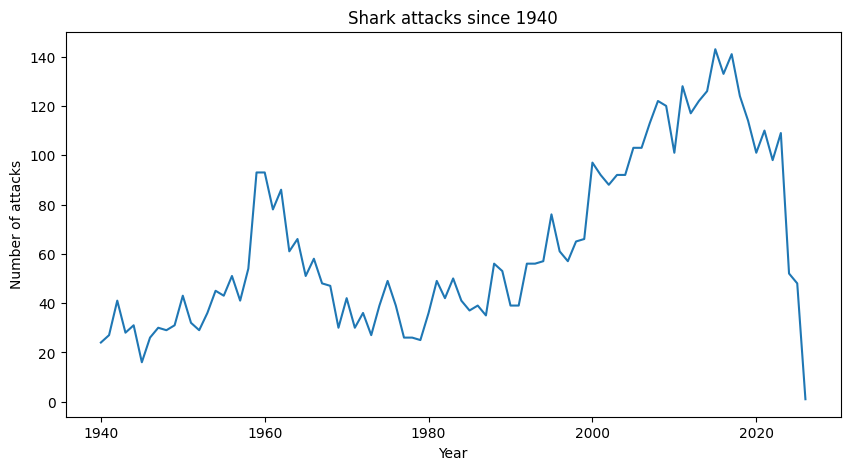

In [ ]:
# Number 3

import matplotlib.pyplot as plt

# Convert Year to numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Filter the rows to focus on attacks since 1940
df_1940 = df[df['Year'] >= 1940]

attacks_per_year = df_1940['Year'].value_counts().sort_index()

# Graph
plt.figure(figsize=(10,5))
attacks_per_year.plot()
plt.xlabel("Year")
plt.ylabel("Number of attacks")
plt.title("Shark attacks since 1940")
plt.show()

Number 3

That values of shark attacks per year seem to vary greatly. Shark attacks seem to be increasing over time, but with COVID, it seems to have drastically dropped as beach attendance probably dropped with the pandemic.

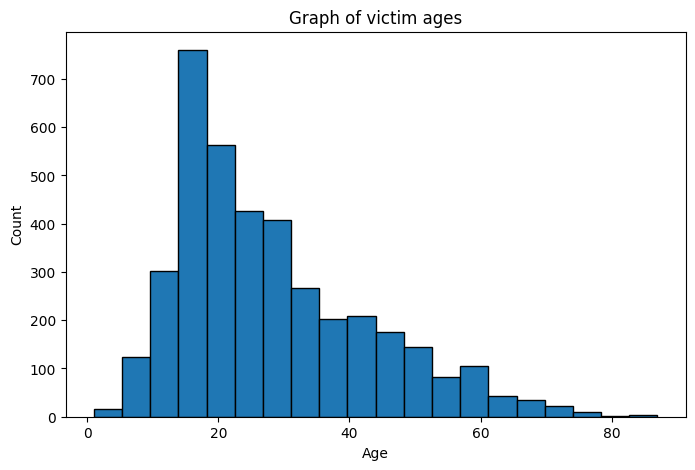

In [40]:
# Number 4

# Remove non-numeric ages
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop missing ages
ages = df['Age'].dropna()

# Graph
plt.figure(figsize=(8,5))
plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Graph of victim ages")
plt.show()

In [42]:
# Number 5

# Standardize the Sex column
df['Sex'] = df['Sex'].str.upper().replace({'M': 'M', 'F': 'F'})

# Calculate proportion of males
male_prop = (df['Sex'] == 'M').mean()
print(f"Proportion of male victims: {male_prop:.2%}")

Proportion of male victims: 80.20%


In [52]:
# Number 6

# Clean the Type variable so it only takes three values: Provoked and Unprovoked and Unknown.
def clean_type(type_val):
    if pd.isna(type_val):
        return 'Unknown'
    
    type_str = str(type_val).upper().strip()
    if 'UNPROVOKED' in type_str:
        return 'Unprovoked'
    elif 'PROVOKED' in type_str:
        return 'Provoked'
    else:
        return 'Unknown'

df['Type_Clean'] = df['Type'].apply(clean_type)
type_counts = df['Type_Clean'].value_counts()

# What proportion of attacks are unprovoked?
print(f"\nProportion of attacks that are unprovoked: {type_counts.get('Unprovoked', 0) / len(df):.1%}")


Proportion of attacks that are unprovoked: 73.8%


In [53]:
# Number 7

# Clean the Fatal Y/N variable so it only takes three values: Y, N, and Unknown.
def clean_fatal(fatal_val):
    if pd.isna(fatal_val):
        return 'Unknown'
    
    fatal_str = str(fatal_val).upper().strip()
    if fatal_str in ['Y', 'YES']:
        return 'Y'
    elif fatal_str in ['N', 'NO']:
        return 'N'
    else:
        return 'Unknown'

In [60]:
# Number 8

# Are sharks more likely to attack men or women unprovoked?
unprovoked = df[df['Type'] == 'Unprovoked']
ct_sex = pd.crosstab(unprovoked['Sex'], unprovoked['Type'], normalize='columns')
print("Proportion of unprovoked attacks by sex:")
print(ct_sex)

# Fatality by attack type
ct_fatal_type = pd.crosstab(df['Type'], df['Fatal Y/N'], normalize='index')
print("\nFatality rate by attack type:")
print(ct_fatal_type)

# Fatality by sex
ct_fatal_sex = pd.crosstab(df['Sex'], df['Fatal Y/N'], normalize='index')
print("\nFatality rate by sex:")
print(ct_fatal_sex)

Proportion of unprovoked attacks by sex:
Type  Unprovoked
Sex             
 M      0.000199
F       0.135415
F       0.000398
LLI     0.000199
M       0.863193
M       0.000597

Fatality rate by attack type:
Fatal Y/N                   N         F         M         N        N   \
Type                                                                    
 provoked            0.000000  0.000000  0.000000  0.500000  0.000000   
?                    0.000000  0.000000  0.000000  1.000000  0.000000   
Boat                 0.000000  0.000000  0.000000  1.000000  0.000000   
Provoked             0.003155  0.000000  0.001577  0.958991  0.000000   
Questionable         0.000000  0.083333  0.000000  0.583333  0.000000   
Sea disaster         0.000000  0.000000  0.000000  0.281513  0.000000   
Under investigation  0.000000  0.000000  0.000000  1.000000  0.000000   
Unknown              0.000000  0.000000  0.000000  0.653846  0.000000   
Unprovoked           0.000965  0.000579  0.000193  0.743436  0

Number 8

Sharks more likely to launch unprovoked attacks on men. Provoked attacks are slightly more likely to be fatal than unprovoked attacks, but both are relatively low. Fatality rates are roughly equal for men and women, maybe slightly higher for women, but the difference is very small. I like sharks!

In [63]:
# Number 9

df['Species '] = df['Species '].str.upper().fillna('UNKNOWN')

white_shark_attacks = df['Species '].str.contains('WHITE', na=False).mean()
print(f"Proportion of attacks by white sharks: {white_shark_attacks:.2%}")

Proportion of attacks by white sharks: 10.68%
